<a href="https://colab.research.google.com/github/megsdata/sEMG_SupervisedLearning/blob/main/23Jun10_All_Enveloped_weightwatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pathlib
import os
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import weightwatcher as ww
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
np.set_printoptions(precision=4)
print(tf.version.VERSION)

2.12.0


In [ ]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(ww.__name__)
logger.setLevel(logging.INFO)

In [ ]:
from google.colab import drive
drive.mount('/MSC_THESIS/')
%cd /MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May28_Training_Data
import pathlib
all_files =  sorted(str(p) for p in pathlib.Path('/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May28_Training_Data/').glob("*.csv"))
#print(all_files)
df = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_21_MATRIX.csv")
for i in range(len(all_files)-1):
  temp = pd.read_csv(all_files[i])
  df = pd.concat([df, temp], axis=0)
  #print(len(df.index))
#df.head()

Mounted at /MSC_THESIS/
/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May28_Training_Data


In [ ]:
df['ContractionDuration'] = df['Contraction End Time (s)'] - df['Contraction Start Time(s)']

In [ ]:
df.head()

,Participant ID,Trial ID,Trial Type,Pulse Width,Contraction Start Time(s),Contraction End Time (s),ContractionNo,Pain Label,Time(s),EMG(mv),Pulse,Stimulus,MMG_x,MMG_y,MMG_z,Ch7,Ch8,ContractionDuration
0,2,21,1,2.770736,8.156866,10.927602,1,1,8.1570,244.901613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.770736
1,2,21,1,2.770736,8.156866,10.927602,1,1,8.1572,245.060525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.770736
2,2,21,1,2.770736,8.156866,10.927602,1,1,8.1574,245.246153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.770736
3,2,21,1,2.770736,8.156866,10.927602,1,1,8.1576,245.453240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.770736
4,2,21,1,2.770736,8.156866,10.927602,1,1,8.1578,245.673745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.770736


Loading the Dataset

In [ ]:
stats_categorical = df['EMG(mv)'].describe().astype(int)
print(stats_categorical)

count    4912371
mean         213
std          160
min            0
25%           83
50%          176
75%          316
max         1006
Name: EMG(mv), dtype: int64


In [ ]:
rslt_df = df[df['Pain Label'] ==0 ]
print('\nResult dataframe :\n', rslt_df)


1,504,659 0 pain labels

In [ ]:
rslt_df = df[df['Pain Label'] ==1 ]
print('\nResult dataframe :\n', rslt_df)

3,372,884 1 pain labels

In [ ]:
del temp
del rslt_df

In [ ]:
import sys
import gc
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable\
    .sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size']\
    .apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable
memory_usage()

Helper Functions

In [ ]:
def data_prep(my_state):
  #select features
  X = df[['EMG(mv)', 'ContractionNo', 'Trial Type', 'ContractionDuration']]
  y = df['Pain Label']
  #create data split
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=my_state)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=my_state)
  print("Number of samples in the training set: ", len(X_train))
  print("Number of samples in the test set: ", len(X_test))
  print("Number of samples in the validation set: ", len(X_val))
  #scale the data
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_val_scaled = scaler.transform(X_val)
  return X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val

In [ ]:
def create_CNN_model(my_state, num_feat):
  tf.random.set_seed(my_state)
  model = tf.keras.Sequential([
      tf.keras.layers.Conv1D(100, num_feat, activation='relu', name="convLayer", input_shape=(num_feat, 1)),
      tf.keras.layers.Dense(128, activation='relu', name="relu1Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu2Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu3Layer"),
      #tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoidLayer")
      tf.keras.layers.Dense(1, activation='relu', name="sigmoidLayer")
  ])

  model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryCrossentropy(name='binary cross entropy'),
        tf.keras.metrics.BinaryIoU(name='binary IoU')
    ]
  )
  return model

def create_LSTM_model(my_state, num_feat):
  tf.random.set_seed(my_state)
  model = tf.keras.Sequential([
      #tf.keras.layers.LSTM(128, input_shape=(num_feat, 1)),
      tf.keras.layers.LSTM(256, input_shape=(num_feat, 1)),
      #tf.keras.layers.Dense(128, activation='relu', name="relu1Layer"),
      #tf.keras.layers.Dense(256, activation='relu', name="relu2Layer"),
      #tf.keras.layers.Dense(256, activation='relu', name="relu3Layer"),
      tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoidLayer")
  ])

def create_regularized_LSTM_model(my_state, factor, rate, num_feat):
  tf.random.set_seed(my_state)
  model = tf.keras.Sequential([
      #Dropout(rate),
      tf.keras.layers.LSTM(256, kernel_regularizer=l2(factor), input_shape=(num_feat, 1)),
      Dropout(rate),
      tf.keras.layers.LSTM(128, input_shape=(256, 1)),
      Dropout(rate),
      tf.keras.layers.Dense(128, kernel_regularizer=l2(factor), activation='relu', name="relu1Layer"),
      Dropout(rate),
      tf.keras.layers.Dense(256, kernel_regularizer=l2(factor), activation='relu', name="relu2Layer"),
      Dropout(rate),
      tf.keras.layers.Dense(256, kernel_regularizer=l2(factor), activation='relu', name="relu3Layer"),
      Dropout(rate),
      tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoidLayer")
      #tf.keras.layers.Dense(1, activation='relu', name="reluLayer")
  ])

  model.compile(
      loss=tf.keras.losses.binary_crossentropy,
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      metrics=[
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.BinaryCrossentropy(name='binary cross entropy'),
          tf.keras.metrics.BinaryIoU(name='binary IoU')
      ]
  )
  return model

def train_model(X_train_scaled,y_train, num_epochs):
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  print("Training the neural network.. ")
  history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=num_epochs, callbacks=[tensorboard_callback])
  model.summary()
  return history

def visualize_performance(num_epochs, history):
  import matplotlib.pyplot as plt
  from matplotlib import rcParams
  rcParams['figure.figsize'] = (18, 8)
  rcParams['axes.spines.top'] = False
  rcParams['axes.spines.right'] = False
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['loss'], label='Loss'
  )
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['accuracy'], label='Accuracy'
  )
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['precision'], label='Precision'
  )
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['recall'], label='Recall'
  )
  plt.title('Evaluation metrics', size=20)
  plt.xlabel('Epoch', size=14)
  plt.legend();

def evaluate_performance(model, X_test_scaled, y_test):
  predictions = model.predict(X_test_scaled)
  prediction_classes = [
      1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
  ]
  prediction_classes = [
      1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
  ]
  from sklearn.metrics import accuracy_score, precision_score, recall_score

  print(f'Accuracy: {accuracy_score(y_test, prediction_classes):.4f}')
  print(f'Precision: {precision_score(y_test, prediction_classes):.4f}')
  print(f'Recall: {recall_score(y_test, prediction_classes):.4f}')

In [ ]:
#choose a random state
%load_ext tensorboard
log_dir = "/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_state = 21
num_epochs = 100
X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val = data_prep(my_state)

Number of samples in the training set:  3143916
Number of samples in the test set:  982475
Number of samples in the validation set:  785980


In [ ]:
model = create_regularized_LSTM_model(my_state, 1e-5, 0.3, 4) #model creation and compilation

ValueError: ignored

In [ ]:
watcher = ww.WeightWatcher(model=model)
details = watcher.analyze()

INFO:weightwatcher:

python      version 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
numpy       version 1.22.4
tensorflow version 2.12.0
keras version 2.12.0
INFO:weightwatcher:

python      version 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
numpy       version 1.22.4
tensorflow version 2.12.0
keras version 2.12.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'fft': False, 'conv2d_fft': False, 'ww2x': False, 'pool': True, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'fast', 'fix_fingers': False, 'fit': 'power_law', 'MAX_FINGERS': 10, 'finger_thresh': 1.0, 'sparsify': True, 'detX': False, 'mp_fit': False, 'min_evals': 10, 'max_evals': 15000, 'max_N': 50000, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, '

In [ ]:
details

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,entropy,has_esd,...,rf,sigma,spectral_norm,stable_rank,status,sv_max,warning,weak_rank_loss,xmax,xmin
0,2,relu1Layer,0.142767,128,128,1.0,12.348588,7.199323,0.937741,True,...,1,4.012332,3.826172,33.75000,success,1.956055,under-trained,0,3.826172,3.085938
1,4,relu2Layer,0.144391,128,256,2.0,3.357870,1.900279,0.971100,True,...,1,0.330168,3.681641,46.28125,success,1.918945,,0,3.681641,1.461914
2,6,relu3Layer,0.120113,256,256,1.0,5.861546,3.523224,0.993053,True,...,1,0.846287,3.992188,64.56250,success,1.998047,,0,3.992188,2.417969


In [ ]:
watcher.get_summary(details)


{'log_norm': 2.252,
 'alpha': 7.189334538179106,
 'alpha_weighted': 4.207608735470654,
 'log_alpha_norm': 5.057983755269125,
 'log_spectral_norm': 0.5835,
 'stable_rank': 48.22}

INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'fft': False, 'conv2d_fft': False, 'ww2x': False, 'pool': True, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'fast', 'fix_fingers': False, 'fit': 'power_law', 'MAX_FINGERS': 10, 'finger_thresh': 1.0, 'sparsify': True, 'detX': False, 'mp_fit': False, 'min_evals': 10, 'max_evals': 15000, 'max_N': 50000, 'tolerance': 1e-06, 'layer_ids_start': 0, 'add_biases': False, 'pl_package': 'ww', 'xmax': None, 'glorot_fit': False, 'layers': [], 'xmin_max': None}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:tensorflow version 2.12.0
keras version 2.12.0
INFO:weightwatcher:framework from model = 4
INFO:weightwatcher:keras layer: lstm_cell <keras.layers.rnn.lstm.LSTMCell object at 0x7f

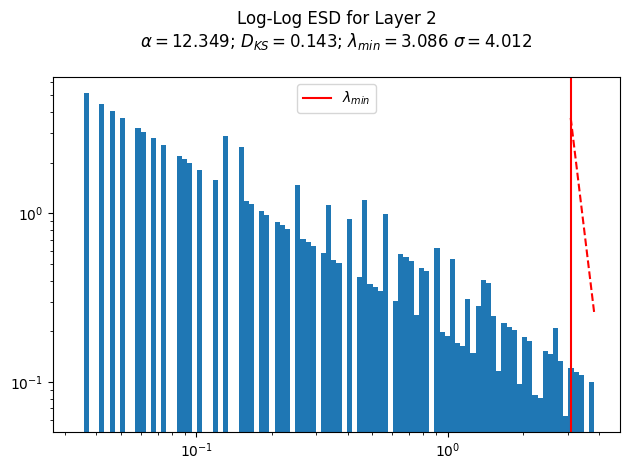

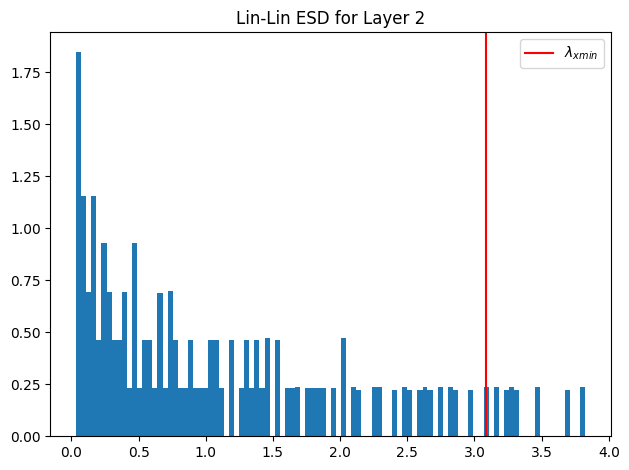

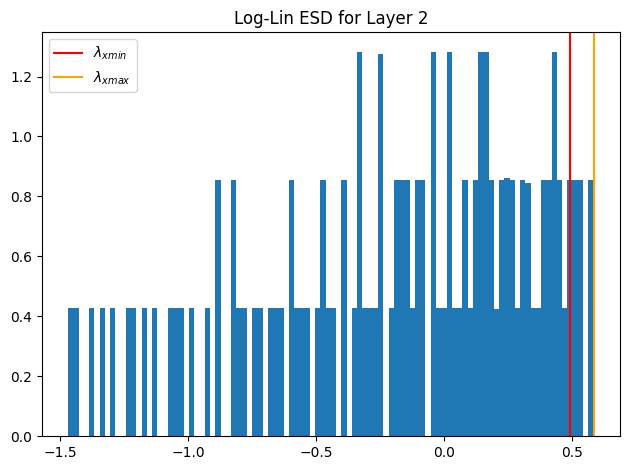

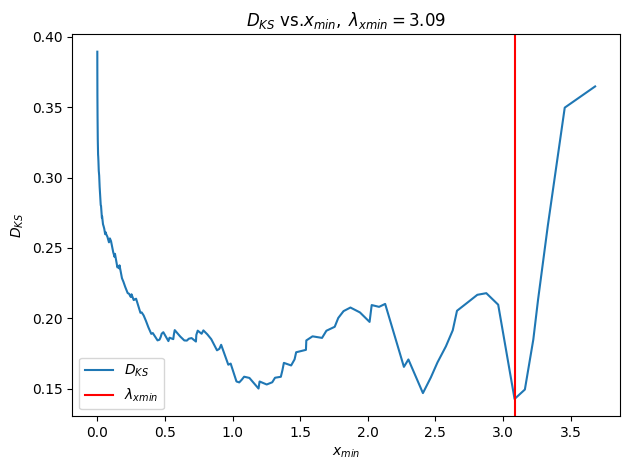

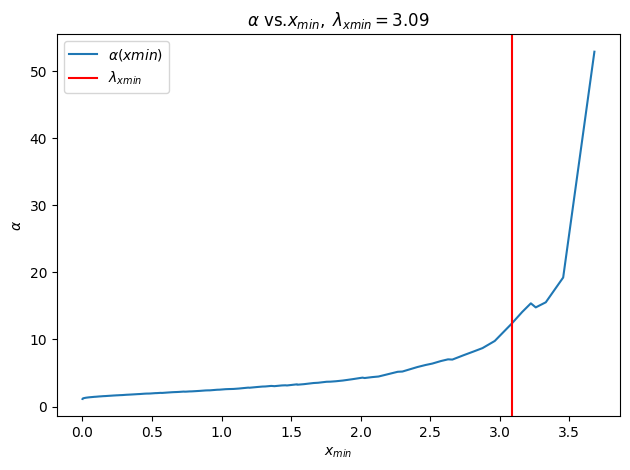

INFO:weightwatcher:keras layer: dropout_1 <keras.layers.regularization.dropout.Dropout object at 0x7f1102a16f80>  type LAYER_TYPE.UNKNOWN not found 
INFO:weightwatcher:Running powerlaw.Fit no xmin, xmax=None. distribution=power_law pl_package=ww
INFO:weightwatcher:PL FIT running NEW power law method


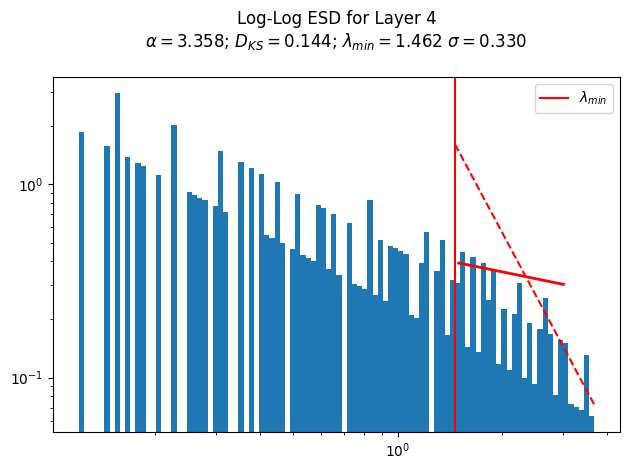

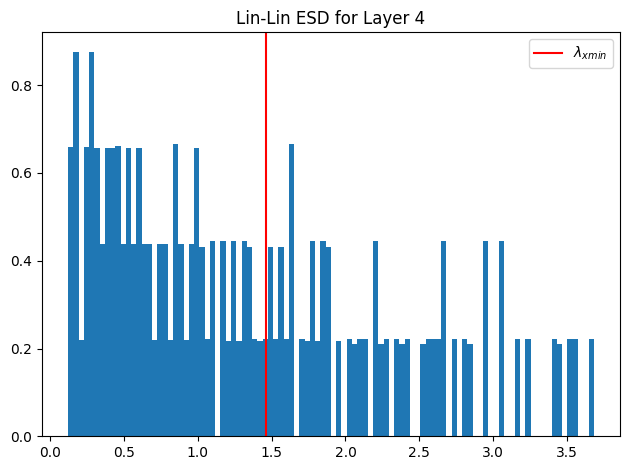

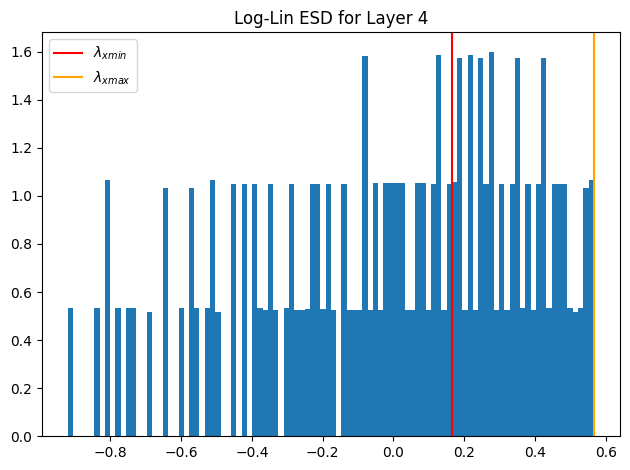

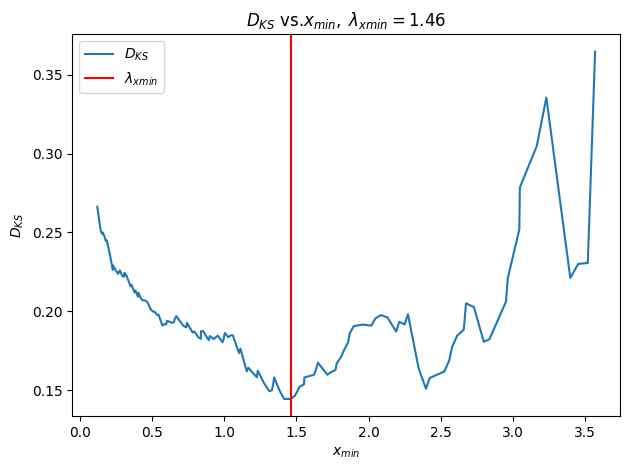

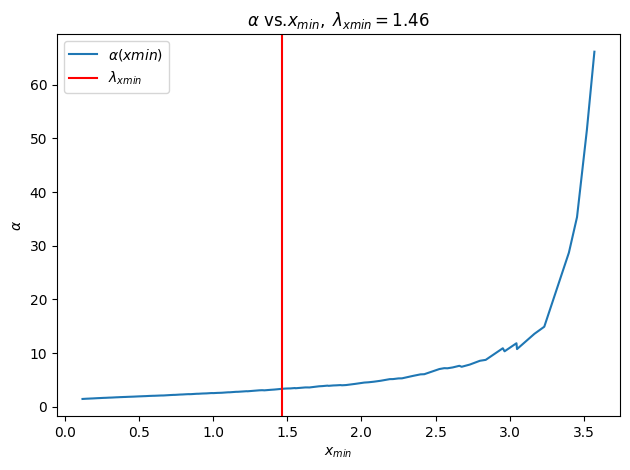

INFO:weightwatcher:keras layer: dropout_2 <keras.layers.regularization.dropout.Dropout object at 0x7f1102a14f70>  type LAYER_TYPE.UNKNOWN not found 
INFO:weightwatcher:Running powerlaw.Fit no xmin, xmax=None. distribution=power_law pl_package=ww
INFO:weightwatcher:PL FIT running NEW power law method


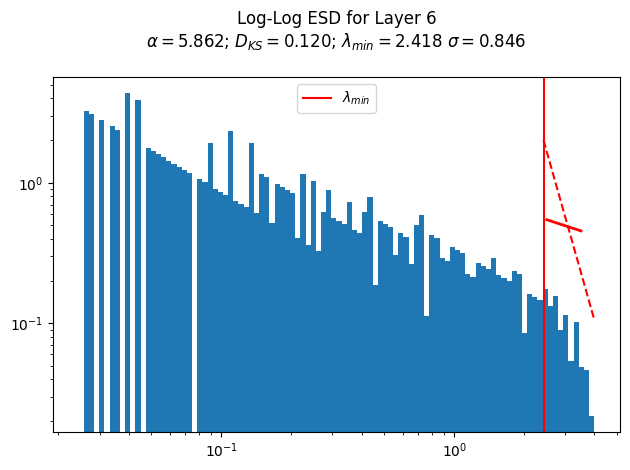

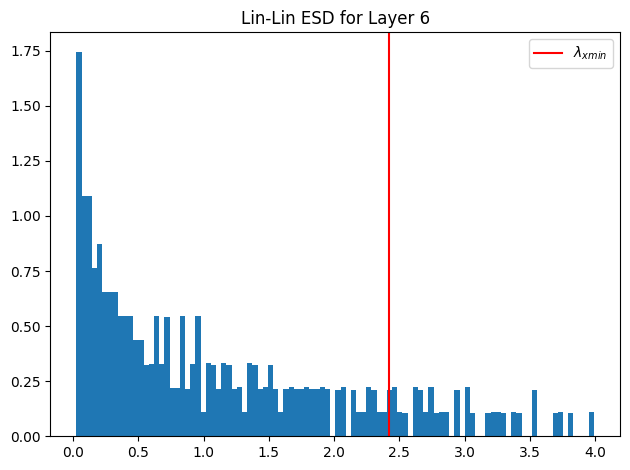

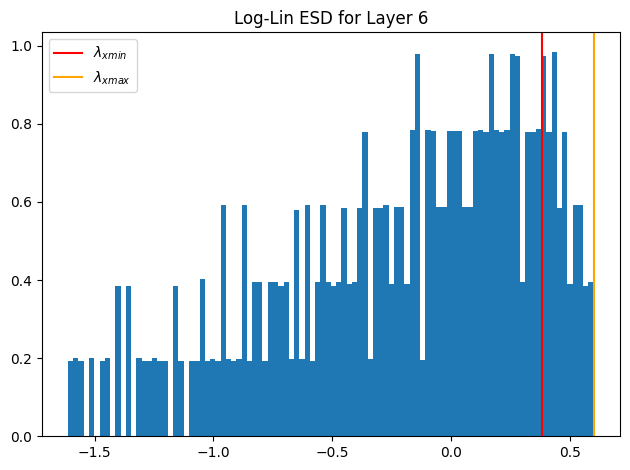

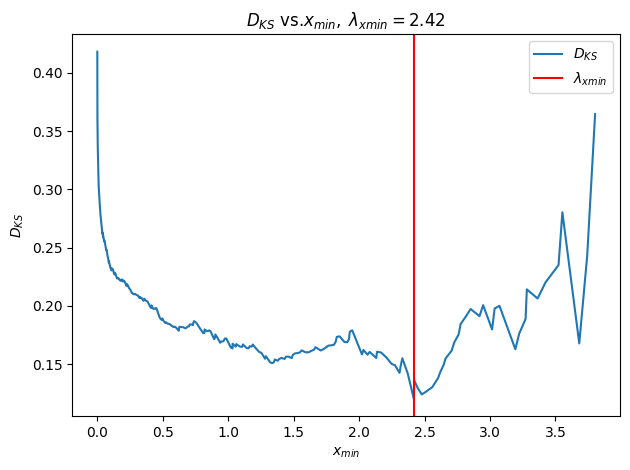

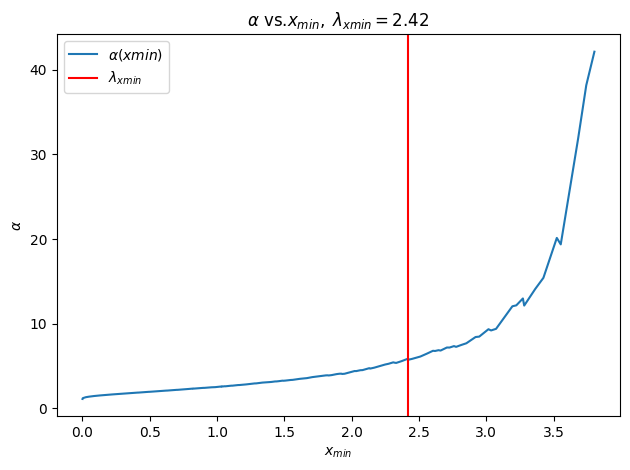

INFO:weightwatcher:keras layer: dropout_3 <keras.layers.regularization.dropout.Dropout object at 0x7f1102a15d50>  type LAYER_TYPE.UNKNOWN not found 


<Figure size 640x480 with 0 Axes>

In [ ]:
details = watcher.analyze(plot=True)

In [ ]:
#model = create_regularized_LSTM_model(my_state, 1e-5, 0.3, 4) #model creation and compilation
history = train_model(X_train_scaled, y_train, num_epochs) #training
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)

Training the neural network.. 
Epoch 1/100
98248/98248 [==============================] - 641s 6ms/step - loss: 0.1700 - accuracy: 0.9376 - precision: 0.9706 - recall: 0.9386 - binary cross entropy: 0.1409 - binary IoU: 0.8669
Epoch 2/100
98248/98248 [==============================] - 627s 6ms/step - loss: 0.1250 - accuracy: 0.9607 - precision: 0.9785 - recall: 0.9646 - binary cross entropy: 0.0915 - binary IoU: 0.9129
Epoch 3/100
98248/98248 [==============================] - 627s 6ms/step - loss: 0.1264 - accuracy: 0.9612 - precision: 0.9762 - recall: 0.9676 - binary cross entropy: 0.0921 - binary IoU: 0.9135
Epoch 4/100
98248/98248 [==============================] - 664s 7ms/step - loss: 0.1185 - accuracy: 0.9642 - precision: 0.9787 - recall: 0.9696 - binary cross entropy: 0.0847 - binary IoU: 0.9202
Epoch 5/100
98248/98248 [==============================] - 660s 7ms/step - loss: 0.1187 - accuracy: 0.9646 - precision: 0.9793 - recall: 0.9694 - binary cross entropy: 0.0850 - binary I

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-c47c578cdb6d>", line 2, in <cell line: 2>
    history = train_model(X_train_scaled, y_train, num_epochs) #training
  File "<ipython-input-13-6570492cfb98>", line 68, in train_model
    history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=num_epochs, callbacks=[tensorboard_callback])
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/plugins/scalar/summary_v2.py", line 89, in scalar
    return tf.summary.write(
tensorflow.python.framework.errors_impl.FailedPreconditionError: {{function_node __wrapped__WriteSummary_device_/job:localhost/replica:0/task:0/device:CPU:0}} /MSC_THESIS/MyDrive/School

In [ ]:
from google.colab import drive
drive.mount('/MSC_THESIS/')
%cd /MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/
fextract_df = pd.read_excel("21-May-2023_COMBINED_ENC.xlsx")
fextract_df.head().T

Mounted at /MSC_THESIS/
/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS


,0,1,2,3,4
SubjectID,20220124M-01,20220124M-01,20220124M-01,20220124M-01,20220124M-01
RandomizedGroup_1_ONFirst_2_OFFFirst_,1,1,1,1,1
SubjectDataFileNames,20220124M-01_T1ON,20220124M-01_T1ON,20220124M-01_T1ON,20220124M-01_T1ON,20220124M-01_T1ON
DateOfCollection_dd_mm_yy_,24/01/2022,24/01/2022,24/01/2022,24/01/2022,24/01/2022
Sex_0_Male_1_Female_,1,1,1,1,1
Age_years_,23,23,23,23,23
Height_cm_,157,157,157,157,157
Weight_kg_,50.0,50.0,50.0,50.0,50.0
DominantL_R_L_,R,R,R,R,R
PreviousLowerLimbInjury_toDominantSide___0_no_1_yes_,0,0,0,0,0


In [ ]:
#select the labels and features
labels = fextract_df['NPRS_0_10_']
features = fextract_df[['Sex_0_Male_1_Female_', 'Age_years_', 'Height_cm_', 'Weight_kg_', \
               'PreviousLowerLimbInjury_toDominantSide___0_no_1_yes_', 'MotorPoint_ENC',\
               'RMS', 'ContractionMax', 'ContractionMin', \
               'ContractionMean', 'ContractionVariance', 'ContractionLength',\
               'contractionAOC', 'meanAbsVal', 'normalizedMean', 'normalizedRMS', 'normalizedStDev', 'stdError', \
               'stdDev']]
print(labels.shape)
print(features.shape)

(315,)
(315, 19)


In [ ]:
def data_prep(my_state):
  #select features
  X = fextract_df[['Sex_0_Male_1_Female_', 'Age_years_', 'Height_cm_', 'Weight_kg_', \
               'PreviousLowerLimbInjury_toDominantSide___0_no_1_yes_', 'MotorPoint_ENC',\
               'RMS', 'ContractionMax', 'ContractionMin', \
               'ContractionMean', 'ContractionVariance', 'ContractionLength',\
               'contractionAOC', 'meanAbsVal', 'normalizedMean', 'normalizedRMS', 'normalizedStDev', 'stdError', \
               'stdDev']]
  y = fextract_df['NPRS_0_10_']
  #create data split
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=my_state)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=my_state)
  print("Number of samples in the training set: ", len(X_train))
  print("Number of samples in the test set: ", len(X_test))
  print("Number of samples in the validation set: ", len(X_val))
  #scale the data
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_val_scaled = scaler.transform(X_val)
  return X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val

In [ ]:
def create_CNN_model(my_state, num_feat):
  tf.random.set_seed(my_state)
  model = tf.keras.Sequential([
      tf.keras.layers.Conv1D(100, num_feat, activation='relu', name="convLayer", input_shape=(num_feat, 1)),
      tf.keras.layers.Dense(128, activation='relu', name="relu1Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu2Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu3Layer"),
      tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoidLayer")
  ])

  model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryCrossentropy(name='binary cross entropy'),
        tf.keras.metrics.BinaryIoU(name='binary IoU')
    ]
  )
  return model

def create_LSTM_model(my_state, num_feat):
  tf.random.set_seed(my_state)
  model = tf.keras.Sequential([
      #tf.keras.layers.LSTM(128, input_shape=(num_feat, 1)),
      tf.keras.layers.LSTM(256, input_shape=(num_feat, 1)),
      #tf.keras.layers.Dense(128, activation='relu', name="relu1Layer"),
      #tf.keras.layers.Dense(256, activation='relu', name="relu2Layer"),
      #tf.keras.layers.Dense(256, activation='relu', name="relu3Layer"),
      tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoidLayer")
  ])

def create_regularized_LSTM_model(my_state, factor, rate, num_feat):
  tf.random.set_seed(my_state)
  model = tf.keras.Sequential([
      #Dropout(rate),
      tf.keras.layers.LSTM(128, kernel_regularizer=l2(factor), input_shape=(num_feat, 1)),
      Dropout(rate),
      tf.keras.layers.Dense(128, kernel_regularizer=l2(factor), activation='relu', name="relu1Layer"),
      Dropout(rate),
      tf.keras.layers.Dense(256, kernel_regularizer=l2(factor), activation='relu', name="relu2Layer"),
      Dropout(rate),
      tf.keras.layers.Dense(256, kernel_regularizer=l2(factor), activation='relu', name="relu3Layer"),
      Dropout(rate),
      tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoidLayer")
  ])

  model.compile(
      loss=tf.keras.losses.binary_crossentropy,
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      metrics=[
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.BinaryCrossentropy(name='binary cross entropy'),
          tf.keras.metrics.BinaryIoU(name='binary IoU')
      ]
  )
  return model

def train_model(X_train_scaled,y_train, num_epochs):
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  print("Training the neural network.. ")
  history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=num_epochs, callbacks=[tensorboard_callback])
  model.summary()
  return history

def visualize_performance(num_epochs, history):
  import matplotlib.pyplot as plt
  from matplotlib import rcParams
  rcParams['figure.figsize'] = (18, 8)
  rcParams['axes.spines.top'] = False
  rcParams['axes.spines.right'] = False
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['loss'], label='Loss'
  )
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['accuracy'], label='Accuracy'
  )
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['precision'], label='Precision'
  )
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['recall'], label='Recall'
  )
  plt.title('Evaluation metrics', size=20)
  plt.xlabel('Epoch', size=14)
  plt.legend();

def evaluate_performance(model, X_test_scaled, y_test):
  predictions = model.predict(X_test_scaled)
  prediction_classes = [
      1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
  ]
  prediction_classes = [
      1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
  ]
  from sklearn.metrics import accuracy_score, precision_score, recall_score

  print(f'Accuracy: {accuracy_score(y_test, prediction_classes):.4f}')
  print(f'Precision: {precision_score(y_test, prediction_classes):.4f}')
  print(f'Recall: {recall_score(y_test, prediction_classes):.4f}')

Number of samples in the training set:  201
Number of samples in the test set:  63
Number of samples in the validation set:  51
Training the neural network.. 
Epoch 1/200
7/7 [==============================] - 4s 34ms/step - loss: 0.7576 - accuracy: 0.6915 - precision: 0.7225 - recall: 0.8993 - binary cross entropy: 0.7520 - binary IoU: 0.4263
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6351 - accuracy: 0.7065 - precision: 0.7041 - recall: 0.9928 - binary cross entropy: 0.6291 - binary IoU: 0.3820
Epoch 3/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6278 - accuracy: 0.7065 - precision: 0.7083 - recall: 0.9784 - binary cross entropy: 0.6214 - binary IoU: 0.3949
Epoch 4/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6062 - accuracy: 0.7114 - precision: 0.7056 - recall: 1.0000 - binary cross entropy: 0.5997 - binary IoU: 0.3850
Epoch 5/200
7/7 [==============================] - 0s 20ms/step - loss: 0.6163 - accuracy: 0.

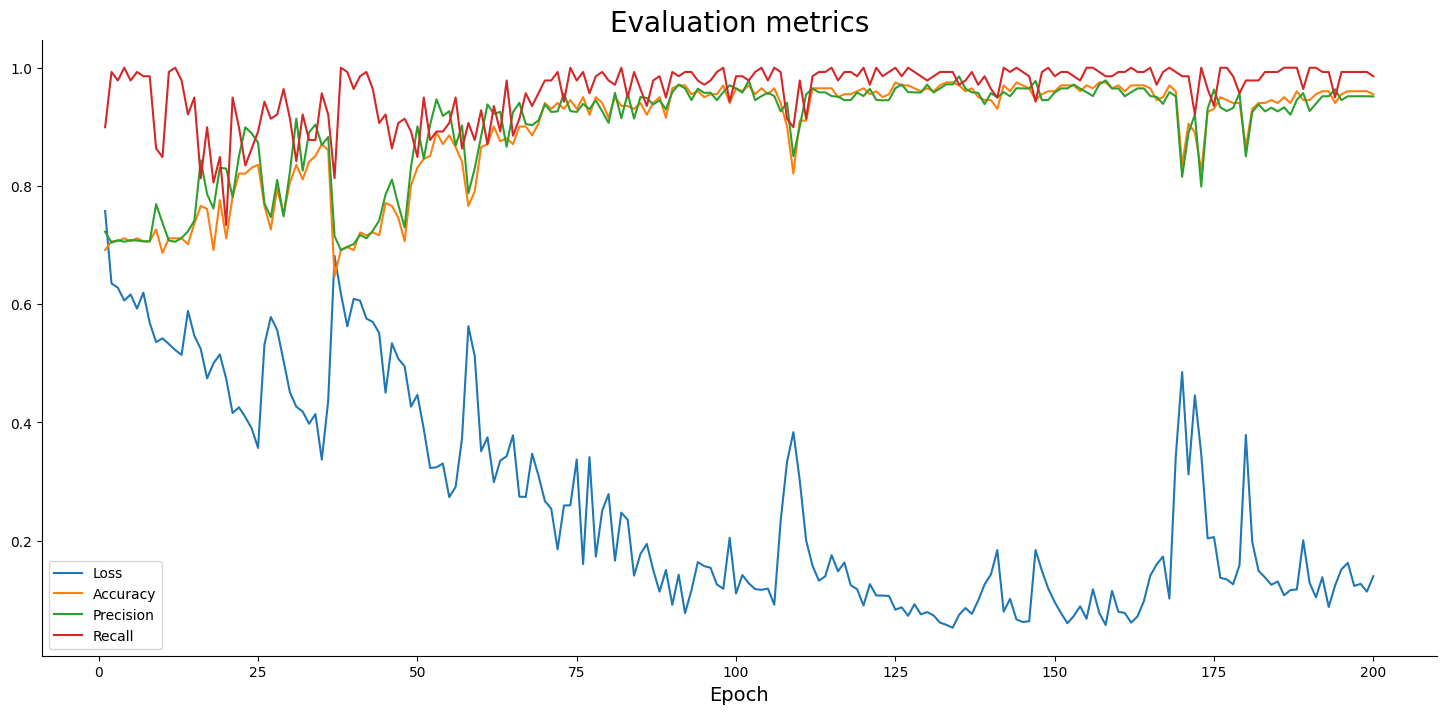

In [ ]:
log_dir = "/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_state = 106
num_epochs = 200
X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val = data_prep(my_state)
model = create_regularized_LSTM_model(my_state, 1e-5, 0.3, 19) #model creation and compilation
history = train_model(X_train_scaled, y_train, num_epochs) #training
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)

Number of samples in the training set:  201
Number of samples in the test set:  63
Number of samples in the validation set:  51
Training the neural network.. 
Epoch 1/200
7/7 [==============================] - 7s 39ms/step - loss: 0.5510 - accuracy: 0.6318 - precision: 0.6897 - recall: 0.8571 - binary cross entropy: 0.5510 - binary IoU: 0.3525
Epoch 2/200
7/7 [==============================] - 0s 18ms/step - loss: 0.3315 - accuracy: 0.8657 - precision: 0.9380 - recall: 0.8643 - binary cross entropy: 0.3315 - binary IoU: 0.7400
Epoch 3/200
7/7 [==============================] - 0s 18ms/step - loss: 0.3081 - accuracy: 0.8955 - precision: 0.8993 - recall: 0.9571 - binary cross entropy: 0.3081 - binary IoU: 0.7755
Epoch 4/200
7/7 [==============================] - 0s 18ms/step - loss: 0.2982 - accuracy: 0.8756 - precision: 0.9528 - recall: 0.8643 - binary cross entropy: 0.2982 - binary IoU: 0.7581
Epoch 5/200
7/7 [==============================] - 0s 18ms/step - loss: 0.1733 - accuracy: 0.

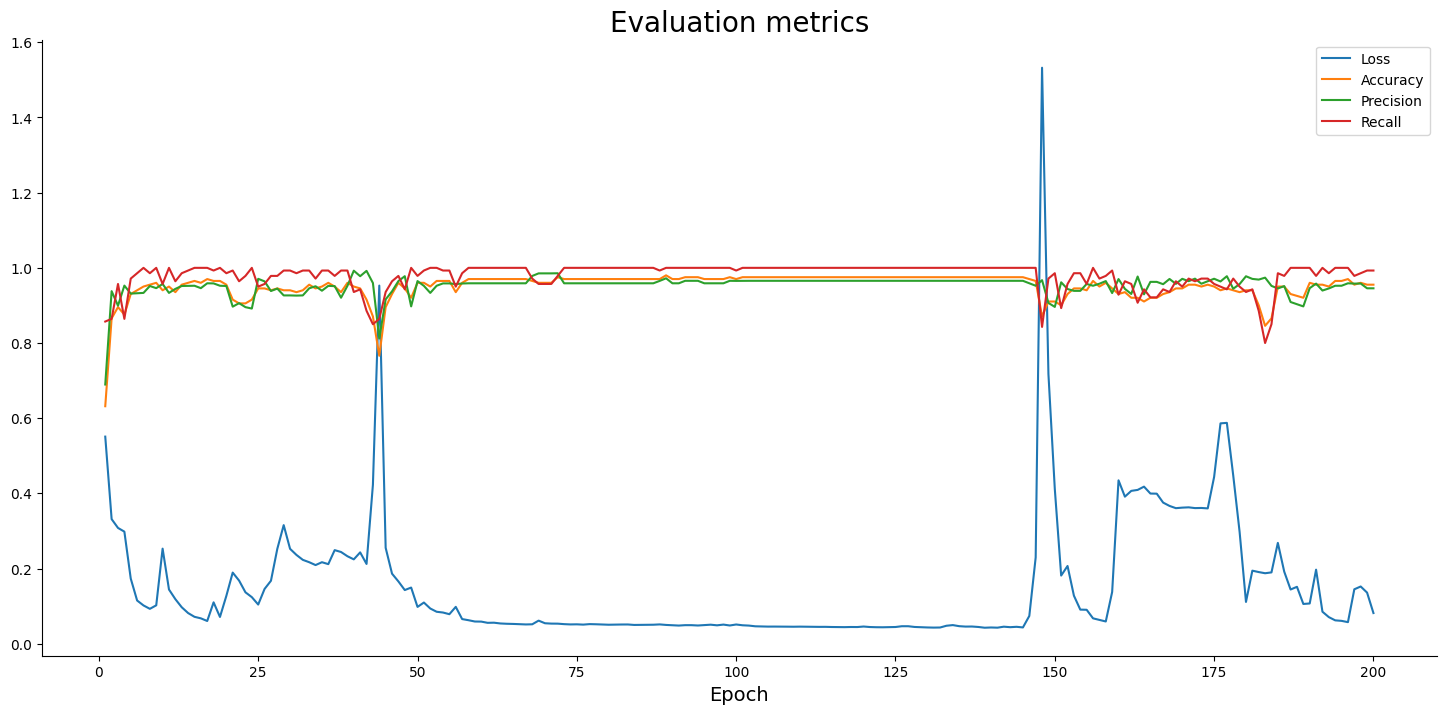

In [ ]:
log_dir = "/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_state = 111
num_epochs = 200
X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val = data_prep(my_state)
model = create_CNN_model(my_state, 19) #model creation and compilation
history = train_model(X_train_scaled, y_train, num_epochs) #training
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)

Undersampling to Balance Dataset

In [ ]:
# Undersample imbalanced dataset with NearMiss-1
from collections import Counter
from imblearn.under_sampling import NearMiss
from numpy import where
# summarize class distribution
counter = Counter(y_train)
print("The ratio of original binary labels is: ", counter)
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X_train_scaled_sampled, y_train_sampled = undersample.fit_resample(X_train_scaled, y_train)
# summarize the new class distribution
counter = Counter(y_train_sampled)
print("The ratio of balanced binary labels is: ", counter)

In [ ]:

model = create_CNN_model(my_state, 19) #model creation and compilation
history = train_model(X_train_scaled, y_train, num_epochs) #training
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)

In [ ]:
%tensorboard --logdir logs/fit

Oversampling to balance dataset

In [ ]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
counter = Counter(y_train)
print("The ratio of original binary labels is: ", counter)
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train_scaled, y_train)
counter = Counter(y_over)
print("The ratio of balanced binary labels is: ", counter)

The ratio of original binary labels is:  Counter({1: 2180507, 0: 963409})
The ratio of balanced binary labels is:  Counter({1: 2180507, 0: 2180507})


In [ ]:
num_epochs = 1
model = create_LSTM_model(my_state) #model creation and compilation
history = train_model(X_over, y_over, num_epochs) #training
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)

RF ON

In [ ]:
#load Rectus femoris ON
df = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_21_MATRIX.csv")
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_31_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_41_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_51_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_61_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_71_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_81_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_91_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_101_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_121_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))


185964
275662
366300
431952
477782
565566
648895
729629
799352


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Number of samples in the training set:  511584
Number of samples in the test set:  159871
Number of samples in the validation set:  127897
Training the neural network.. 
15987/15987 [==============================] - 84s 5ms/step - loss: 0.2184 - accuracy: 0.9044 - precision: 0.9215 - recall: 0.9752 - binary cross entropy: 0.2184 - binary IoU: 0.5974
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               264192    
                                                                 
 sigmoidLayer (Dense)        (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
4

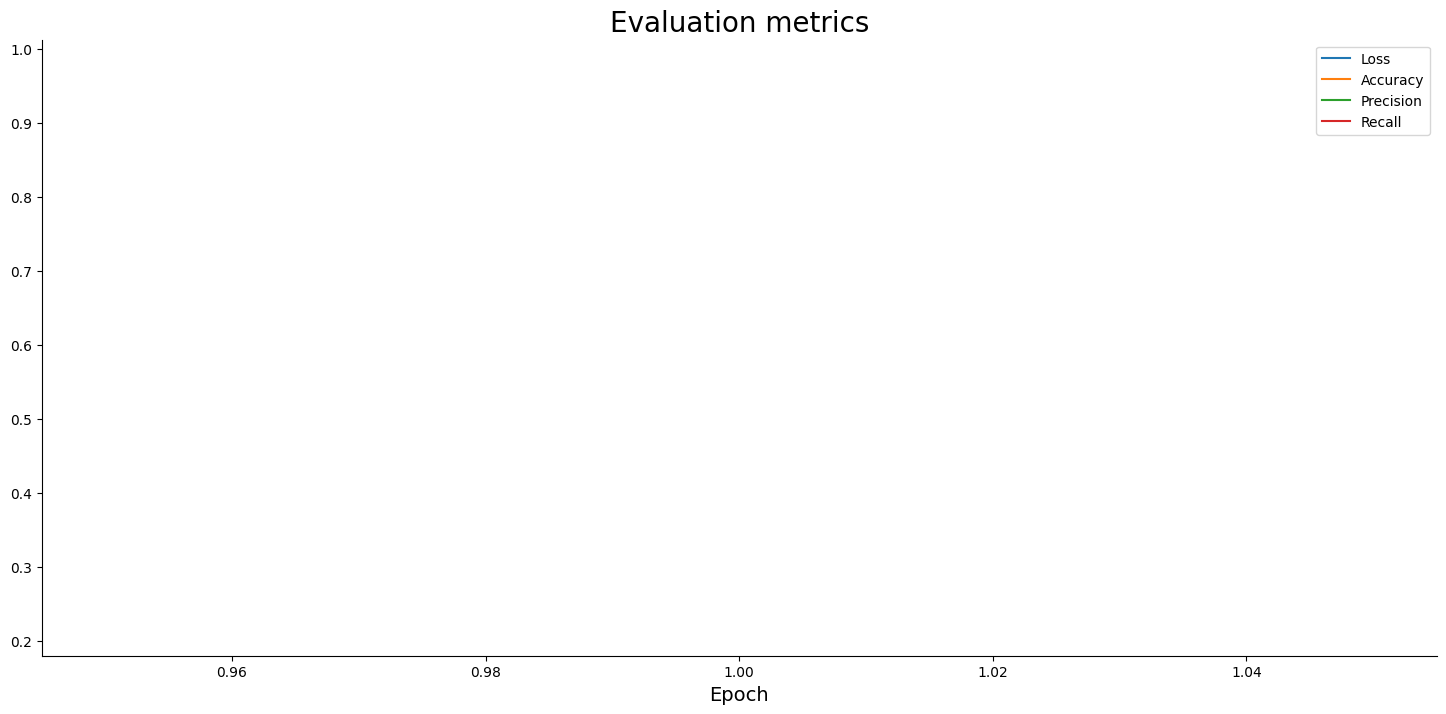

In [ ]:
#choose a random state
%load_ext tensorboard
log_dir = "/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_state = 52
num_epochs = 1
X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val = data_prep(my_state)
model = create_LSTM_model(my_state) #model creation and compilation
history = train_model(X_train_scaled, y_train, num_epochs) #training
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)

RF OFF

In [ ]:
#Rectus femoris OFF
df = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_14_MATRIX.csv")
#df = pd.concat([df, temp], axis=0)
#print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_24_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_44_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_54_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_64_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_74_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_84_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_94_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))
temp = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23May31_Envelope_Data/_124_MATRIX.csv")
df = pd.concat([df, temp], axis=0)
print(len(df.index))

187906
295179
374662
439802
468527
560869
651433
703291


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Number of samples in the training set:  450105
Number of samples in the test set:  140659
Number of samples in the validation set:  112527
Training the neural network.. 
14066/14066 [==============================] - 80s 5ms/step - loss: 0.4759 - accuracy: 0.7693 - precision: 0.7961 - recall: 0.7651 - binary cross entropy: 0.4759 - binary IoU: 0.6244
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               264192    
                                                                 
 sigmoidLayer (Dense)        (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
4

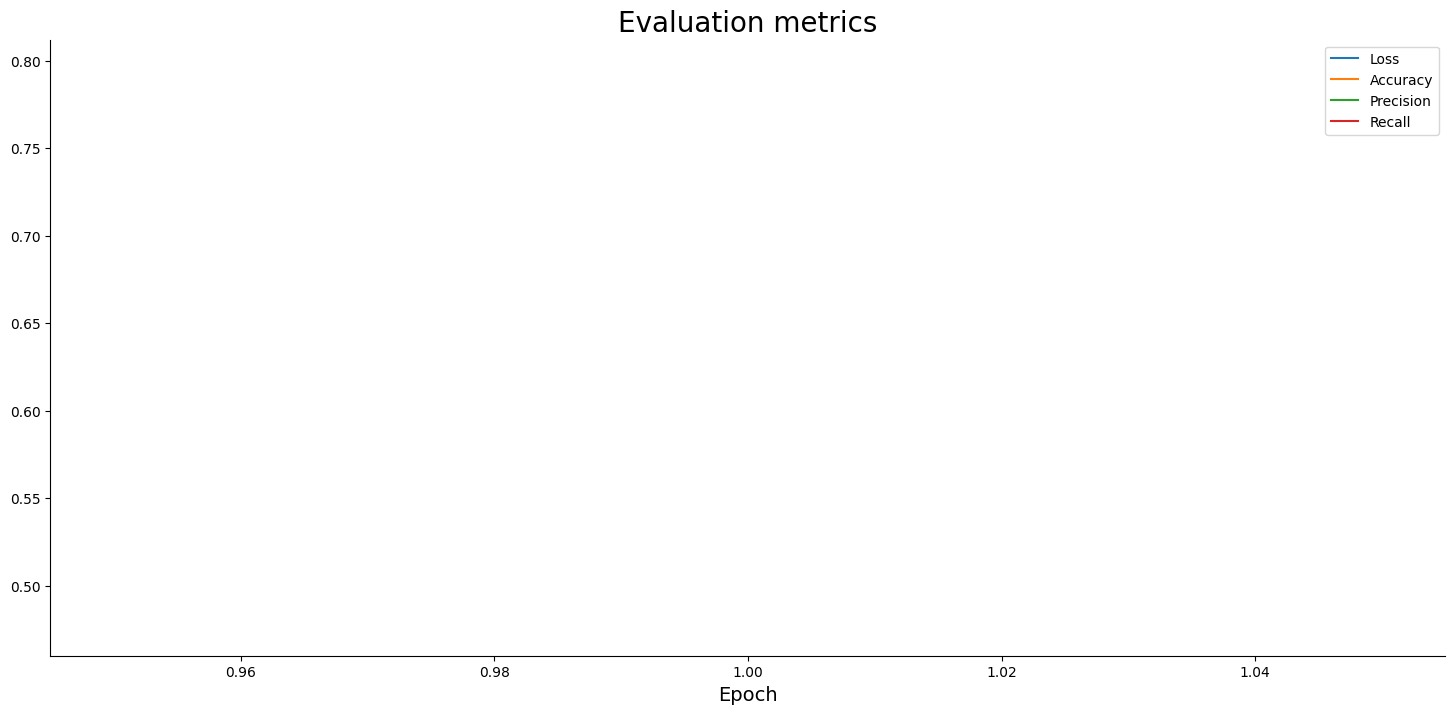

In [ ]:
#choose a random state
%load_ext tensorboard
log_dir = "/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_state = 53
num_epochs = 1
X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val = data_prep(my_state)
model = create_LSTM_model(my_state) #model creation and compilation
history = train_model(X_train_scaled, y_train, num_epochs) #training
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)